# [AI-Driven Stock Insights: Analyzing Financial News with LLM](https://developers.lseg.com/en/article-catalog/article/ai-driven-stock-insights--analyzing-financial-news-with-llms)
# Import Libraries

In [63]:
!pip install yfinance
!pip install nbformat
!pip install --upgrade nbformat


In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

from datetime import datetime, timedelta
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import plotly.express as px
import tqdm
import yfinance as yf
tqdm.tqdm.pandas()

c:\Users\Nitro\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\data\metrics\__init__.py:19: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import pearsonr, spearmanr


# BTC Stock Price History

In [2]:
d_now = datetime.now().date()
max_end_date = d_now - timedelta(days=300) # upto months=15
print(f'start date is: {max_end_date}\nend date is: {d_now} (today)')

start date is: 2024-05-29
end date is: 2025-03-25 (today)


In [3]:

stock = yf.Ticker('BTC-USD')
start_date = max_end_date
end_date = d_now
hist = stock.history(start=start_date, end=end_date)
hist_df = pd.DataFrame(hist)

In [4]:
hist_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-29 00:00:00+00:00,68296.351562,68852.460938,67101.492188,67578.093750,26707072906,0.0,0.0
2024-05-30 00:00:00+00:00,67576.085938,69500.539062,67118.078125,68364.992188,29509712534,0.0,0.0
2024-05-31 00:00:00+00:00,68362.515625,68999.562500,66633.421875,67491.414062,27387283769,0.0,0.0
2024-06-01 00:00:00+00:00,67489.609375,67839.765625,67386.195312,67706.937500,11641495604,0.0,0.0
2024-06-02 00:00:00+00:00,67710.273438,68409.164062,67315.523438,67751.601562,17110588415,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-20 00:00:00+00:00,86872.953125,87443.265625,83647.195312,84167.195312,29028988961,0.0,0.0
2025-03-21 00:00:00+00:00,84164.539062,84782.273438,83171.070312,84043.242188,19030452299,0.0,0.0
2025-03-22 00:00:00+00:00,84046.257812,84513.875000,83674.781250,83832.484375,9863214091,0.0,0.0


# Retrieve News Headline
### Open File From SET_News_.csv

In [5]:
news_df = pd.read_csv("BTC_News_.csv")
news_df.head()

,Unnamed: 0,versionCreated,headline,storyId,sourceCode
0,0,2025-03-18 23:54:08.068,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,urn:link:webnews:20250318:nNRAvri2k4:0,NS:WNCOMA
1,1,2025-03-18 23:53:09.131,"Current sentiment analysis for BNB, Chainlink, Wrapped Bitcoin, Solana. Bitcoin in only slightly positive territory",urn:newsml:newsroom:20250318:nNRAvri2jd:0,NS:CRYPEE
2,2,2025-03-18 23:53:06.832,Report: North Korea Quietly Becomes the Worlds 3rd-Largest Bitcoin Superpower,urn:link:webnews:20250318:nNRAvri2wu:0,NS:MSNUKA
3,3,2025-03-18 23:27:43.875,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,urn:newsml:newsroom:20250318:nNRAvrhxuf:0,NS:CRYPTT
4,4,2025-03-18 23:25:06.448,Bitcoin UTXO P/L Ratio Hits 50.2 – A 30-Point Drop Could Signal the End Of This Correction,urn:link:webnews:20250318:nNRAvrhwdb:0,NS:BITCOI


# Data Preparation

In [6]:
news_df['versionCreated'] = pd.to_datetime(news_df['versionCreated'])

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame
filtered_news = news_df[(news_df['versionCreated'] >= start_date) & (news_df['versionCreated'] <= end_date)]
filtered_news.head()

,Unnamed: 0,versionCreated,headline,storyId,sourceCode
0,0,2025-03-18 23:54:08.068,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,urn:link:webnews:20250318:nNRAvri2k4:0,NS:WNCOMA
1,1,2025-03-18 23:53:09.131,"Current sentiment analysis for BNB, Chainlink, Wrapped Bitcoin, Solana. Bitcoin in only slightly positive territory",urn:newsml:newsroom:20250318:nNRAvri2jd:0,NS:CRYPEE
2,2,2025-03-18 23:53:06.832,Report: North Korea Quietly Becomes the Worlds 3rd-Largest Bitcoin Superpower,urn:link:webnews:20250318:nNRAvri2wu:0,NS:MSNUKA
3,3,2025-03-18 23:27:43.875,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,urn:newsml:newsroom:20250318:nNRAvrhxuf:0,NS:CRYPTT
4,4,2025-03-18 23:25:06.448,Bitcoin UTXO P/L Ratio Hits 50.2 – A 30-Point Drop Could Signal the End Of This Correction,urn:link:webnews:20250318:nNRAvrhwdb:0,NS:BITCOI


In [7]:
filtered_news.columns

Index(['Unnamed: 0', 'versionCreated', 'headline', 'storyId', 'sourceCode'], dtype='object')

In [8]:
filtered_news = filtered_news.drop(columns=['Unnamed: 0', 'storyId', 'sourceCode'])
filtered_news.head()


,versionCreated,headline
0,2025-03-18 23:54:08.068,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC
1,2025-03-18 23:53:09.131,"Current sentiment analysis for BNB, Chainlink, Wrapped Bitcoin, Solana. Bitcoin in only slightly positive territory"
2,2025-03-18 23:53:06.832,Report: North Korea Quietly Becomes the Worlds 3rd-Largest Bitcoin Superpower
3,2025-03-18 23:27:43.875,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC
4,2025-03-18 23:25:06.448,Bitcoin UTXO P/L Ratio Hits 50.2 – A 30-Point Drop Could Signal the End Of This Correction


In [9]:
filtered_news.loc[:, 'date'] = pd.to_datetime(filtered_news.versionCreated, format="%Y-%m-%d %H:%M:%S.%f").dt.date
filtered_news.index = filtered_news['versionCreated']
filtered_news = filtered_news.drop(columns=['versionCreated'])
filtered_news.head()



,headline,date
versionCreated,,
2025-03-18 23:54:08.068,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,2025-03-18
2025-03-18 23:53:09.131,"Current sentiment analysis for BNB, Chainlink, Wrapped Bitcoin, Solana. Bitcoin in only slightly positive territory",2025-03-18
2025-03-18 23:53:06.832,Report: North Korea Quietly Becomes the Worlds 3rd-Largest Bitcoin Superpower,2025-03-18
2025-03-18 23:27:43.875,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,2025-03-18
2025-03-18 23:25:06.448,Bitcoin UTXO P/L Ratio Hits 50.2 – A 30-Point Drop Could Signal the End Of This Correction,2025-03-18


In [10]:
hist_df.to_csv('dataset/historical_pricing.csv')
filtered_news.to_csv('dataset/news_headline.csv')

## Select only first news each day

In [11]:
filtered_news.drop_duplicates(subset=['date'], inplace=True)
filtered_news

,headline,date
versionCreated,,
2025-03-18 23:54:08.068,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,2025-03-18
2025-03-17 23:38:06.756,Sentiment analysis for important coins. Bitcoin currently in negative territory,2025-03-17
2025-03-16 23:36:08.366,South Korean Central Bank 'Negative' About Launching Strategic Bitcoin Reserve,2025-03-16
2025-03-15 23:51:58.464,Elon Musk's Favorite Dogecoin Sees Massive Sell-Off-Miners Dump 65M DOGE in 48 Hours,2025-03-15
2025-03-14 23:37:06.978,Weekly: The Hour Glass (AGS: SGD1.58) decreases 0.6% on weak volume; -1c [0.6%],2025-03-14
2025-03-13 23:58:14.660,B.C. court grants production order to man defrauded out of $26 million in bitcoin,2025-03-13
2025-03-12 23:46:59.468,State-backed Bolivian energy firm YPFB turns to crypto amid painful dollar shortage,2025-03-12
2025-03-11 23:58:40.075,"Why Are Bitcoin, XRP, Dogecoin, and Cardano Prices Going Up Today?",2025-03-11
2025-03-10 23:56:06.291,"Recession risks roil markets as investors dump stocks, bitcoin",2025-03-10


# Sentiment Analysis using OpenAI chat completion

In [12]:
pretrained_model = 'ahmedrachid/FinancialBERT-Sentiment-Analysis'
model = BertForSequenceClassification.from_pretrained(pretrained_model,num_labels=3)
tokenizer = BertTokenizer.from_pretrained(pretrained_model)

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def sentiment_analysis(sentences):
    return nlp(sentences)[0]['label']

start_time = time.time()

filtered_news['Good news'] = filtered_news['headline'].apply(sentiment_analysis)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:",execution_time)

Execution time: 3.4469988346099854


In [13]:
filtered_news['Good news'] = filtered_news['Good news'].map({'neutral': 'UNKNOWN', 'negative': 'NO', 'positive': 'YES'})

In [14]:
pd.set_option('display.max_rows', None)
filtered_news

,headline,date,Good news
versionCreated,,,
2025-03-18 23:54:08.068,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,2025-03-18,YES
2025-03-17 23:38:06.756,Sentiment analysis for important coins. Bitcoin currently in negative territory,2025-03-17,NO
2025-03-16 23:36:08.366,South Korean Central Bank 'Negative' About Launching Strategic Bitcoin Reserve,2025-03-16,UNKNOWN
2025-03-15 23:51:58.464,Elon Musk's Favorite Dogecoin Sees Massive Sell-Off-Miners Dump 65M DOGE in 48 Hours,2025-03-15,UNKNOWN
2025-03-14 23:37:06.978,Weekly: The Hour Glass (AGS: SGD1.58) decreases 0.6% on weak volume; -1c [0.6%],2025-03-14,NO
2025-03-13 23:58:14.660,B.C. court grants production order to man defrauded out of $26 million in bitcoin,2025-03-13,NO
2025-03-12 23:46:59.468,State-backed Bolivian energy firm YPFB turns to crypto amid painful dollar shortage,2025-03-12,UNKNOWN
2025-03-11 23:58:40.075,"Why Are Bitcoin, XRP, Dogecoin, and Cardano Prices Going Up Today?",2025-03-11,UNKNOWN
2025-03-10 23:56:06.291,"Recession risks roil markets as investors dump stocks, bitcoin",2025-03-10,NO


# Visualization

<Axes: title={'center': 'Good news vs Bad news'}, xlabel='Good news'>

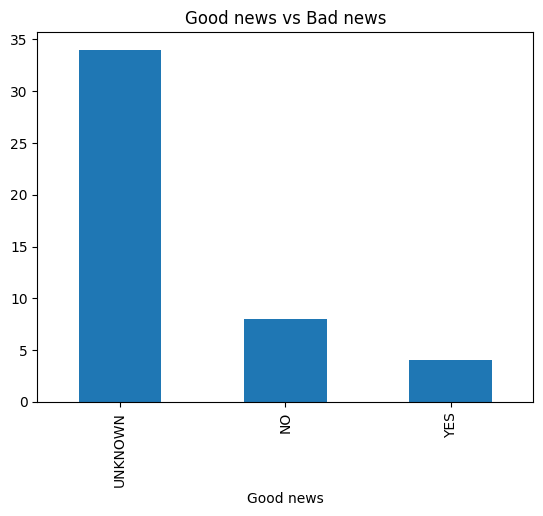

In [15]:
filtered_news['Good news'].value_counts().plot.bar(title='Good news vs Bad news')

In [16]:
filtered_news.to_csv('dataset/news_headline_sentiment.csv', index=False)

In [17]:
news_headlines_df = pd.read_csv('dataset/news_headline_sentiment.csv', parse_dates=['date'])
news_headlines_df

,headline,date,Good news
0,Congressman Nick Begich signals growing support for The Bitcoin Act to acquire 1 million BTC,2025-03-18,YES
1,Sentiment analysis for important coins. Bitcoin currently in negative territory,2025-03-17,NO
2,South Korean Central Bank 'Negative' About Launching Strategic Bitcoin Reserve,2025-03-16,UNKNOWN
3,Elon Musk's Favorite Dogecoin Sees Massive Sell-Off-Miners Dump 65M DOGE in 48 Hours,2025-03-15,UNKNOWN
4,Weekly: The Hour Glass (AGS: SGD1.58) decreases 0.6% on weak volume; -1c [0.6%],2025-03-14,NO
5,B.C. court grants production order to man defrauded out of $26 million in bitcoin,2025-03-13,NO
6,State-backed Bolivian energy firm YPFB turns to crypto amid painful dollar shortage,2025-03-12,UNKNOWN
7,"Why Are Bitcoin, XRP, Dogecoin, and Cardano Prices Going Up Today?",2025-03-11,UNKNOWN
8,"Recession risks roil markets as investors dump stocks, bitcoin",2025-03-10,NO
9,Bitcoin Dips Again As The Market Takes Hectic Rollercoaster Ride,2025-03-09,UNKNOWN


In [18]:
price_df = pd.read_csv('dataset/historical_pricing.csv', parse_dates=['Date'])
price_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-05-29 00:00:00+00:00,68296.351562,68852.460938,67101.492188,67578.093750,26707072906,0.0,0.0
1,2024-05-30 00:00:00+00:00,67576.085938,69500.539062,67118.078125,68364.992188,29509712534,0.0,0.0
2,2024-05-31 00:00:00+00:00,68362.515625,68999.562500,66633.421875,67491.414062,27387283769,0.0,0.0
3,2024-06-01 00:00:00+00:00,67489.609375,67839.765625,67386.195312,67706.937500,11641495604,0.0,0.0
4,2024-06-02 00:00:00+00:00,67710.273438,68409.164062,67315.523438,67751.601562,17110588415,0.0,0.0
5,2024-06-03 00:00:00+00:00,67753.898438,70230.820312,67589.835938,68804.781250,32401285324,0.0,0.0
6,2024-06-04 00:00:00+00:00,68804.570312,71047.406250,68564.640625,70567.765625,33149696545,0.0,0.0
7,2024-06-05 00:00:00+00:00,70568.351562,71735.414062,70390.710938,71082.820312,32810771409,0.0,0.0
8,2024-06-06 00:00:00+00:00,71082.843750,71625.734375,70119.125000,70757.164062,25223152007,0.0,0.0
9,2024-06-07 00:00:00+00:00,70759.187500,71907.851562,68507.257812,69342.585938,36188381096,0.0,0.0


# Plot price with News sentiment

In [19]:
from visualization import plot_price_with_news
plot_price_with_news(price_df, news_headlines_df.sample(frac=0.5, random_state=7)).show()

In [20]:
plot_price_with_news(price_df, news_headlines_df.sample(frac=0.2, random_state=7)).show()

In [21]:
plot_price_with_news(price_df, news_headlines_df.sample(frac=0.1, random_state=7)).show()

In [23]:
plot_price_with_news(price_df, news_headlines_df).show()